In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import copy
from losses import *
import time
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

losschoice = 'digamma'
num_classes = 2
num_epochs = 30
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ""#"sample"

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16


In [3]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


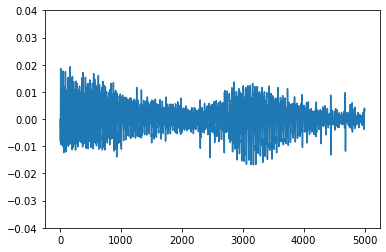

In [4]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [5]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'wingbeatraw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))


In [6]:
if losschoice == 'digamma':
    criterion = edl_digamma_loss
elif losschoice == 'log':
    criterion = edl_log_loss
elif losschoice == 'mse':
    criterion = edl_mse_loss
else:
    criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)

## Training

In [7]:
dataloaders = {"train": train_dataloader,
               "val": valid_dataloader}

# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
device = 'cuda'
model = model.to(device, dtype=torch.float)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

losses = {"loss": [], "phase": [], "epoch": []}
accuracy = {"accuracy": [], "phase": [], "epoch": []}
evidences = {"evidence": [], "type": [], "epoch": []}

Train on gpu: True


In [8]:
since = time.time()

for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    running_loss = 0.0
    running_corrects = 0.0
    correct = 0

    for phase in ['train','val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0
        correct = 0

        for i, (x_batch,y_batch,path_batch,idx_batch) in tqdm(enumerate(dataloaders[phase]), desc=f"Epoch: {epoch}, {phase.capitalize()}"):

            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):

                labels = y_batch
                y = one_hot_embedding(y_batch)
                y = y.to(device)
                outputs = model(x_batch)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, y.float(), epoch, num_classes, 10, device)

                match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
                acc = torch.mean(match)
                evidence = relu_evidence(outputs)
                alpha = evidence + 1
                u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

                total_evidence = torch.sum(evidence, 1, keepdim=True)
                mean_evidence = torch.mean(total_evidence)
                mean_evidence_succ = torch.sum(torch.sum(evidence, 1, keepdim=True) * match) / torch.sum(match + 1e-20)
                mean_evidence_fail = torch.sum(torch.sum(evidence, 1, keepdim=True) * (1 - match)) / (torch.sum(torch.abs(1 - match)) + 1e-20)
                
            if phase == 'train':
                loss.backward()
                optimizer.step()
#                 correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

            # statistics
            running_loss += loss.item() *x_batch.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if scheduler is not None:
            if phase == "val":
                scheduler.step(loss)
                early_stopping(loss, model)
            
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        losses["loss"].append(epoch_loss)
        losses["phase"].append(phase)
        losses["epoch"].append(epoch)
        accuracy["accuracy"].append(epoch_acc.item())
        accuracy["epoch"].append(epoch)
        accuracy["phase"].append(phase)

        print(f"{phase.capitalize()} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")            
        # deep copy the model
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print("Training complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))
print("Best val Acc: {:4f}".format(best_acc))

Epoch: 0, Train: 758it [03:21,  3.76it/s]


Train loss: 0.3111 acc: 0.8812


Epoch: 0, Val: 95it [01:08,  1.38it/s]


Validation loss decreased (inf --> 3.365533).  Saving model ...
Val loss: 3.3158 acc: 0.4063


Epoch: 1, Train: 758it [00:07, 96.55it/s] 

Train loss: 0.2498 acc: 0.9198



Epoch: 1, Val: 95it [00:00, 99.97it/s] 


Validation loss decreased (3.365533 --> 0.836749).  Saving model ...
Val loss: 0.9564 acc: 0.7098


Epoch: 2, Train: 758it [00:09, 79.88it/s]

Train loss: 0.2442 acc: 0.9281



Epoch: 2, Val: 95it [00:01, 94.18it/s] 

Val loss: 1.6024 acc: 0.6222



Epoch: 3, Train: 758it [00:08, 90.96it/s]

Train loss: 0.2360 acc: 0.9351



Epoch: 3, Val: 95it [00:01, 68.86it/s] 

Val loss: 1.5402 acc: 0.6580



Epoch: 4, Train: 758it [00:08, 86.27it/s]

Train loss: 0.2195 acc: 0.9404



Epoch: 4, Val: 95it [00:01, 92.71it/s] 

Validation loss decreased (0.836749 --> 0.559727).  Saving model ...
Val loss: 0.5262 acc: 0.8483



Epoch: 5, Train: 758it [00:08, 87.97it/s]

Train loss: 0.2155 acc: 0.9431



Epoch: 5, Val: 95it [00:01, 91.78it/s] 


Val loss: 4.4201 acc: 0.4365


Epoch: 6, Train: 758it [00:08, 87.33it/s] 

Train loss: 0.2086 acc: 0.9462



Epoch: 6, Val: 95it [00:00, 101.04it/s]

Val loss: 0.9724 acc: 0.7497



Epoch: 7, Train: 758it [00:08, 92.12it/s] 

Train loss: 0.2046 acc: 0.9493



Epoch: 7, Val: 95it [00:00, 103.02it/s]

Validation loss decreased (0.559727 --> 0.140852).  Saving model ...
Val loss: 0.1981 acc: 0.9515



Epoch: 8, Train: 758it [00:08, 94.40it/s]

Train loss: 0.2006 acc: 0.9526



Epoch: 8, Val: 95it [00:01, 88.28it/s] 

Val loss: 0.2592 acc: 0.9340



Epoch: 9, Train: 758it [00:08, 90.85it/s]

Train loss: 0.1951 acc: 0.9535



Epoch: 9, Val: 95it [00:00, 104.78it/s]

Val loss: 1.6742 acc: 0.6999



Epoch: 10, Train: 758it [00:08, 90.90it/s]

Train loss: 0.1869 acc: 0.9561



Epoch: 10, Val: 95it [00:00, 98.20it/s] 

Val loss: 5.2010 acc: 0.4263



Epoch: 11, Train: 758it [00:08, 84.72it/s]

Train loss: 0.1865 acc: 0.9591



Epoch: 11, Val: 95it [00:01, 89.94it/s] 

Epoch    12: reducing learning rate of group 0 to 1.0000e-03.
Val loss: 2.6418 acc: 0.6222



Epoch: 12, Train: 758it [00:08, 91.84it/s] 

Train loss: 0.1431 acc: 0.9697



Epoch: 12, Val: 95it [00:00, 102.83it/s]

Validation loss decreased (0.140852 --> 0.046660).  Saving model ...
Val loss: 0.1334 acc: 0.9685



Epoch: 13, Train: 758it [00:08, 93.40it/s] 

Train loss: 0.1281 acc: 0.9732



Epoch: 13, Val: 95it [00:00, 101.08it/s]

Val loss: 0.1298 acc: 0.9713



Epoch: 14, Train: 758it [00:08, 92.15it/s]

Train loss: 0.1184 acc: 0.9759



Epoch: 14, Val: 95it [00:00, 100.51it/s]

Val loss: 0.1516 acc: 0.9660



Epoch: 15, Train: 758it [00:08, 93.66it/s]

Train loss: 0.1133 acc: 0.9768



Epoch: 15, Val: 95it [00:00, 102.95it/s]

Val loss: 0.4637 acc: 0.8973



Epoch: 16, Train: 758it [00:07, 94.94it/s] 

Train loss: 0.1099 acc: 0.9784



Epoch: 16, Val: 95it [00:00, 99.66it/s] 

Validation loss decreased (0.046660 --> 0.041027).  Saving model ...
Val loss: 0.1358 acc: 0.9705



Epoch: 17, Train: 758it [00:08, 92.32it/s]

Train loss: 0.1048 acc: 0.9788



Epoch: 17, Val: 95it [00:00, 100.71it/s]

Val loss: 0.1493 acc: 0.9659



Epoch: 18, Train: 758it [00:08, 91.55it/s]

Train loss: 0.1016 acc: 0.9813



Epoch: 18, Val: 95it [00:00, 100.70it/s]

Val loss: 0.1245 acc: 0.9746



Epoch: 19, Train: 758it [00:08, 92.99it/s] 

Train loss: 0.0983 acc: 0.9812



Epoch: 19, Val: 95it [00:00, 103.10it/s]


Val loss: 0.3925 acc: 0.9157


Epoch: 20, Train: 758it [00:07, 96.11it/s] 

Train loss: 0.0934 acc: 0.9833



Epoch: 20, Val: 95it [00:00, 101.56it/s]

Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Val loss: 0.1782 acc: 0.9603



Epoch: 21, Train: 758it [00:08, 85.76it/s]

Train loss: 0.0865 acc: 0.9847



Epoch: 21, Val: 95it [00:00, 102.82it/s]

Validation loss decreased (0.041027 --> 0.036915).  Saving model ...
Val loss: 0.1212 acc: 0.9746



Epoch: 22, Train: 758it [00:08, 91.42it/s]

Train loss: 0.0863 acc: 0.9856



Epoch: 22, Val: 95it [00:00, 102.47it/s]

Validation loss decreased (0.036915 --> 0.036899).  Saving model ...
Val loss: 0.1210 acc: 0.9749



Epoch: 23, Train: 758it [00:08, 90.96it/s]

Train loss: 0.0862 acc: 0.9850



Epoch: 23, Val: 95it [00:01, 92.83it/s] 

Validation loss decreased (0.036899 --> 0.034956).  Saving model ...
Val loss: 0.1222 acc: 0.9748



Epoch: 24, Train: 758it [00:08, 91.52it/s] 


Train loss: 0.0849 acc: 0.9851


Epoch: 24, Val: 95it [00:00, 101.75it/s]

Val loss: 0.1211 acc: 0.9748



Epoch: 25, Train: 758it [00:08, 92.02it/s]

Train loss: 0.0833 acc: 0.9858



Epoch: 25, Val: 95it [00:00, 100.98it/s]

Val loss: 0.1214 acc: 0.9748



Epoch: 26, Train: 758it [00:08, 89.58it/s] 

Train loss: 0.0823 acc: 0.9860



Epoch: 26, Val: 95it [00:01, 92.51it/s] 

Val loss: 0.1216 acc: 0.9751



Epoch: 27, Train: 758it [00:08, 91.38it/s]

Train loss: 0.0818 acc: 0.9858



Epoch: 27, Val: 95it [00:01, 88.97it/s] 

Validation loss decreased (0.034956 --> 0.033454).  Saving model ...
Val loss: 0.1235 acc: 0.9733



Epoch: 28, Train: 758it [00:08, 93.56it/s] 

Train loss: 0.0820 acc: 0.9858



Epoch: 28, Val: 95it [00:00, 104.33it/s]

Val loss: 0.1229 acc: 0.9749



Epoch: 29, Train: 758it [00:08, 94.06it/s]

Train loss: 0.0815 acc: 0.9863



Epoch: 29, Val: 95it [00:00, 100.63it/s]

Validation loss decreased (0.033454 --> 0.032841).  Saving model ...
Val loss: 0.1267 acc: 0.9726
Training complete in 9m 21s
Best val Acc: 0.975099


In [9]:
state = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
torch.save(state, f"model_uncertainty_{losschoice}.pt")

In [8]:
checkpoint = torch.load(f"model_uncertainty_{losschoice}.pt")

In [9]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [10]:
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [11]:
model.eval()

Conv1dNetRAW(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (relu3): ReLU()
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu4): ReLU()
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [12]:
daph = WingbeatsDataset(dsname="Aphids_Gnats_v2/aphidsgnats", custom_label=[3], clean=True, transform=transforms.Compose(transforms_list))

Found 18544 in dataset: Aphids_Gnats_v2/aphidsgnats, and 1 label(s): ['aphidsgnats']
Label(s) changed to [3]


In [13]:
dpip = WingbeatsDataset(dsname="Wingbeats/C. pipiens", custom_label=[3], clean=True, transform=transforms.Compose(transforms_list))

Found 29475 in dataset: Wingbeats/C. pipiens, and 1 label(s): ['C. pipiens']
Label(s) changed to [3]


In [14]:
dzap = WingbeatsDataset(dsname="LG/LG_zapr_26_09", custom_label=[3], clean=True, transform=transforms.Compose(transforms_list))

Found 7022 in dataset: LG/LG_zapr_26_09, and 1 label(s): ['LG_zapr_26_09']
Label(s) changed to [3]


In [16]:
dset = dpip
rdm = np.random.randint(0, len(dset))
model = model.to('cpu', dtype=torch.float)

predicts, probabs, uncerts = [],[],[]
for i in range(len(dset)):
    wbt_variable = torch.from_numpy(np.expand_dims(dset[i][0], axis=0))
    wbt_variable = wbt_variable#.to(device)

    output = model(wbt_variable)
    evidence = relu_evidence(output)
    alpha = evidence + 1
    uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
    _, preds = torch.max(output, 1)
    prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
    output = output.flatten()
    prob = prob.flatten()
    preds = preds.flatten()
    print("Predict:", preds[0])
    print("Probs:", prob)
    print("Uncertainty:", uncertainty)
    predicts.append(preds.to('cpu'))
    probabs.append(prob.to('cpu'))
    uncerts.append(uncertainty.to('cpu'))
#     del wbt_variable, output, prob, preds, evidence, uncertainty

Predict: tensor(1)
Probs: tensor([0.0152, 0.9848], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0304]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0116, 0.9884], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0232]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0154, 0.9846], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0307]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0170, 0.9830], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0339]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0353, 0.9647], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0705]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0167, 0.9833], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0335]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0489, 0.9511], grad_fn=<ViewBackward>)
Uncertainty: tensor([[0.0978]], grad_fn=<MulBackward0>)
Predict: tensor(1)
Probs: tensor([0.0797, 0.9203], grad_fn=<ViewBackward>)
Uncertai

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-d752395aa459>", line 7, in <module>
    wbt_variable = torch.from_numpy(np.expand_dims(dset[i][0], axis=0))
  File "/home/kalfasyan/projects/wbai/wingbeat_datasets.py", line 70, in __getitem__
    wbt = open_wingbeat(fname, plot=False)
  File "/home/kalfasyan/projects/wbai/utils.py", line 26, in open_wingbeat
    waveform, sample_rate = torchaudio.load(str(fname))
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/_soundfile_backend.py", line 109, in load
    with soundfile.SoundFile(filepath, "r") as file_:
  File "/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/soundfile.py", line 629, in __init__
    self._file = self._open(file, mode_int, closefd)
  File "/home/kalfasyan/anaconda3/envs/

TypeError: object of type 'NoneType' has no len()

In [26]:
pd.Series(uncerts).apply(lambda x: x[0][0].detach().numpy()).median()

0.047762446105480194

## Testing

### testing on datasets with same conditions

In [11]:
# # Choosing whether to train on a gpu
# train_on_gpu = torch.cuda.is_available()
# print(f'Train on gpu: {train_on_gpu}')# Number of gpus
# model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [2]:
# test_dataset = ConcatDataset([dmel2, dsuz2])
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

# def test(model, loader):
#     correct_test = 0
#     model.eval()
#     for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

#         y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
#         x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

#         pred = model(x_batch)
#         val_loss = criterion(pred, y_batch)
#         correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
#     test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
#     print(test_accuracy)

In [3]:
# test(model,test_dataloader)